Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
Setup complete.
Original Image Dimensions: 512x512

Isolated Running Score Region:


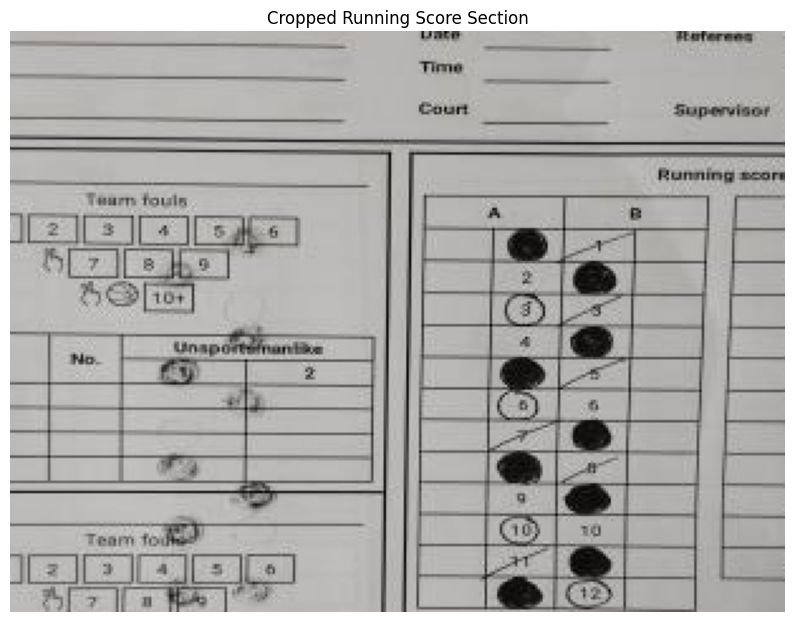

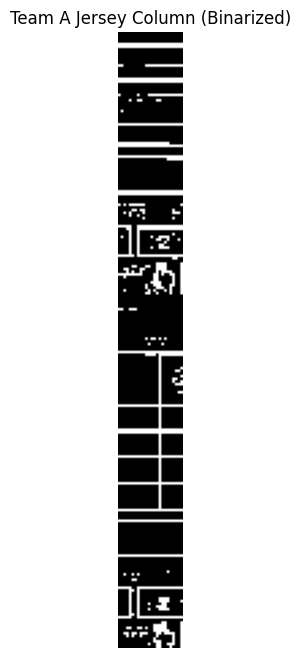

Team A Detected Numbers (Raw OCR): 

Team A Cleaned Numbers: []


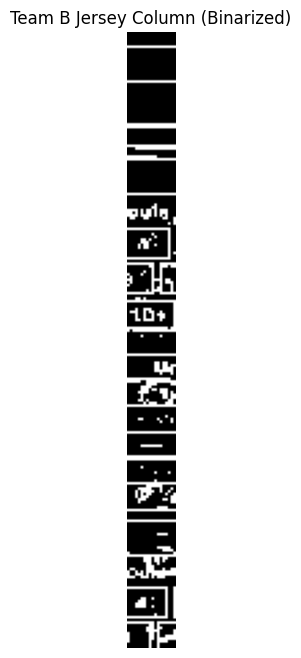

Team B Detected Numbers (Raw OCR): 

Team B Cleaned Numbers: []

--- FINAL EXTRACTED JERSEY NUMBERS ---
Team A: []
Team B: []


In [7]:
# --- Setup and Imports ---
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow # Necessary for Colab display

# Install Tesseract for future OCR steps
!apt install tesseract-ocr
!pip install pytesseract --quiet
import pytesseract
print("Setup complete.")

# --- 1. Image Loading ---
#image_path = 'Sample_Scoring_Sheet.jpeg'
image_path = 'img4.jpg'
img = cv2.imread(image_path)

if img is None:
    print(f"Error: Could not load image from {image_path}. Check file name.")
    exit()

# Get image dimensions
H, W, _ = img.shape
print(f"Original Image Dimensions: {W}x{H}")

# --- 2. Define Region of Interest (ROI) for Running Score ---
# We define normalized coordinates (0 to 1) for the target area.

# Normalized Coordinates for Running Score column (adjust as needed for better crop)
# Y_start: Top of the first score (just below "Running score" title)
# Y_end: Bottom of the last score (just above the Timeouts/Team Fouls section)
# X_start: Start of the score boxes/jersey numbers (left side)
# X_end: End of the score boxes/jersey numbers (right side)

norm_x_start = 0.20  # Starting at 20% of the image width (more left margin)
norm_x_end = 0.80    # Ending at 80% of the image width (more right margin)
norm_y_start = 0.20  # Starting at 20% of the image height (more top margin)
#norm_y_end = 0.95    # Ending at 95% of the image height (more bottom margin)
norm_y_end = 0.65    # Ending at 65% of the image height (more bottom margin)

# --- 3. Calculate Pixel Coordinates and Crop ---
x_start = int(W * norm_x_start)
x_end = int(W * norm_x_end)
y_start = int(H * norm_y_start)
y_end = int(H * norm_y_end)

# Crop the image
cropped_roi = img[y_start:y_end, x_start:x_end]
cropped_roi_rgb = cv2.cvtColor(cropped_roi, cv2.COLOR_BGR2RGB)

# --- 4. Display Result ---
print("\nIsolated Running Score Region:")
plt.figure(figsize=(10, 10))
plt.imshow(cropped_roi_rgb)
plt.title("Cropped Running Score Section")
plt.axis('off')
plt.show()

# Get dimensions of the cropped Running Score region
H_roi, W_roi, _ = cropped_roi.shape

# --- 1. Define Columns within the Cropped ROI (Relative to the wide crop) ---

# Based on the scoresheet structure, we estimate the narrow jersey number columns:
# Team A Jersey Numbers are roughly between 2% and 18% of the ROI width.
# Team B Jersey Numbers are roughly between 52% and 68% of the ROI width.

# Team A Jersey Column X-coordinates
teamA_x_start = int(W_roi * 0.00)
teamA_x_end = int(W_roi * 0.08)

# Team B Jersey Column X-coordinates
teamB_x_start = int(W_roi * 0.18)
teamB_x_end = int(W_roi * 0.24)

# --- 2. Isolate and Process Team A Column ---

teamA_jersey_col = cropped_roi[:, teamA_x_start:teamA_x_end]
teamA_gray = cv2.cvtColor(teamA_jersey_col, cv2.COLOR_BGR2GRAY)

# Apply Adaptive Thresholding
teamA_binary = cv2.adaptiveThreshold(
    teamA_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
)

plt.figure(figsize=(4, 8))
plt.imshow(teamA_binary, cmap='gray')
plt.title("Team A Jersey Column (Binarized)")
plt.axis('off')
plt.show()

# Run Tesseract OCR (digits only)
custom_config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789'
detected_text_A = pytesseract.image_to_string(teamA_binary, config=custom_config)

numbers_A = [n.strip() for n in detected_text_A.split('\n') if n.strip().isdigit() and n.strip()]
print(f"Team A Detected Numbers (Raw OCR): \n{detected_text_A}")
print(f"Team A Cleaned Numbers: {numbers_A}")


# --- 3. Isolate and Process Team B Column ---

teamB_jersey_col = cropped_roi[:, teamB_x_start:teamB_x_end]
teamB_gray = cv2.cvtColor(teamB_jersey_col, cv2.COLOR_BGR2GRAY)

# Apply Adaptive Thresholding
teamB_binary = cv2.adaptiveThreshold(
    teamB_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
)

plt.figure(figsize=(4, 8))
plt.imshow(teamB_binary, cmap='gray')
plt.title("Team B Jersey Column (Binarized)")
plt.axis('off')
plt.show()

# Run Tesseract OCR (digits only)
detected_text_B = pytesseract.image_to_string(teamB_binary, config=custom_config)

numbers_B = [n.strip() for n in detected_text_B.split('\n') if n.strip().isdigit() and n.strip()]
print(f"Team B Detected Numbers (Raw OCR): \n{detected_text_B}")
print(f"Team B Cleaned Numbers: {numbers_B}")

print("\n--- FINAL EXTRACTED JERSEY NUMBERS ---")
print(f"Team A: {numbers_A}")
print(f"Team B: {numbers_B}")